In [1]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import ossaudiodev
from datetime import datetime
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from textblob import TextBlob
from wordcloud import WordCloud

from gensim import corpora
from gensim.models import LdaModel


In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
# Load the CSV file
file_path = r'C:\Users\MSI\Documents\start\Financial_News_and_Stock_Price_Integration_Dataset_Analysist\dataset\raw_analyst_ratings.csv'  # Replace with your actual file path
df = pd.read_csv(file_path)



Descriptive Statistics for Headline Lengths:
count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


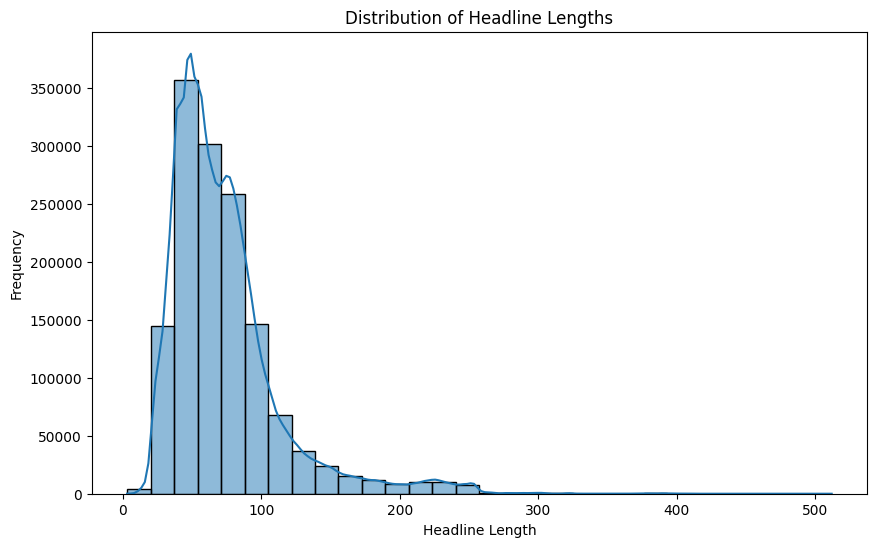


Number of Articles per Publisher:
publisher
Paul Quintaro                      228373
Lisa Levin                         186979
Benzinga Newsdesk                  150484
Charles Gross                       96732
Monica Gerson                       82380
                                    ...  
Shazir Mucklai - Imperium Group         1
Laura Jennings                          1
Eric Martin                             1
Jose Rodrigo                            1
Jeremie Capron                          1
Name: count, Length: 1034, dtype: int64


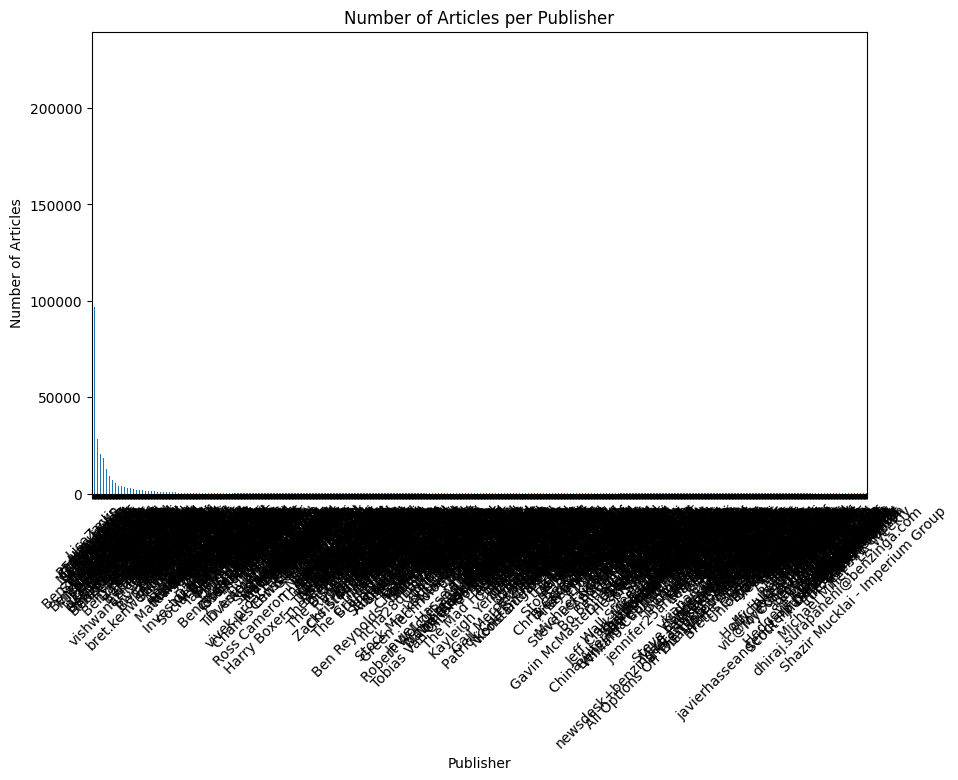


Number of Articles Published Over Time:
publication_date
2009-02-14      1
2009-04-27      2
2009-04-29      1
2009-05-22      1
2009-05-27      6
             ... 
2020-05-30     14
2020-05-31     17
2020-06-01    205
2020-06-02    183
2020-06-03     69
Length: 3946, dtype: int64


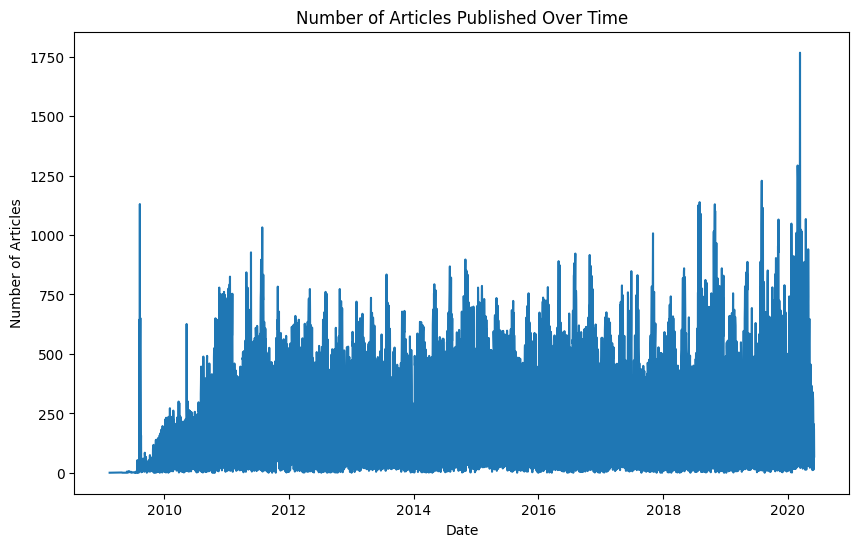


Number of Articles by Day of the Week:
day_of_week
Monday       254842
Tuesday      285468
Wednesday    289049
Thursday     289907
Friday       208511
Saturday       7486
Sunday        16078
Name: count, dtype: int64


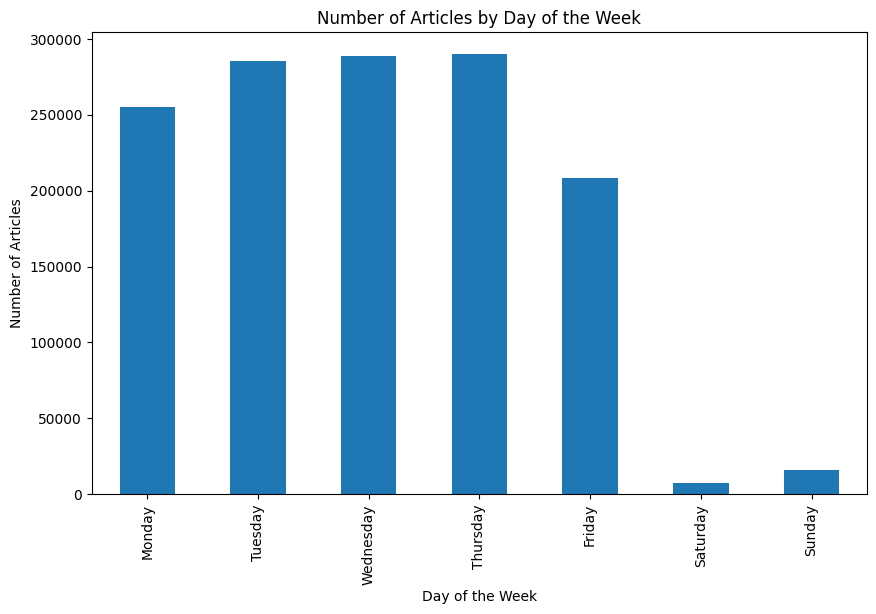

In [5]:
# Convert the date column to datetime format
# Using format='%Y-%m-%d %H:%M:%S' to match your data format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Task 1: Descriptive Statistics for textual lengths (like headline length)
df['headline_length'] = df['headline'].apply(len)
headline_stats = df['headline_length'].describe()
print("Descriptive Statistics for Headline Lengths:")
print(headline_stats)

# Visualize the distribution of headline lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['headline_length'], bins=30, kde=True)
plt.title('Distribution of Headline Lengths')
plt.xlabel('Headline Length')
plt.ylabel('Frequency')
plt.show()

# Task 2: Count the number of articles per publisher
publisher_counts = df['publisher'].value_counts()
print("\nNumber of Articles per Publisher:")
print(publisher_counts)

# Visualize the number of articles per publisher
plt.figure(figsize=(10, 6))
publisher_counts.plot(kind='bar')
plt.title('Number of Articles per Publisher')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.show()

# Task 3: Analyze publication dates to see trends over time
# Extracting the date part (ignoring the time)
df['publication_date'] = df['date'].dt.date
df['day_of_week'] = df['date'].dt.day_name()

# Group by date to get the number of articles per day
articles_per_day = df.groupby('publication_date').size()

print("\nNumber of Articles Published Over Time:")
print(articles_per_day)

# Visualize the number of articles over time
plt.figure(figsize=(10, 6))
articles_per_day.plot(kind='line')
plt.title('Number of Articles Published Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.show()

# Analyze the number of articles by day of the week
articles_by_day = df['day_of_week'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
print("\nNumber of Articles by Day of the Week:")
print(articles_by_day)

# Visualize the number of articles by day of the week
plt.figure(figsize=(10, 6))
articles_by_day.plot(kind='bar')
plt.title('Number of Articles by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Articles')
plt.show()


Sentiment Distribution:
sentiment
neutral     934928
positive    341161
negative    131239
Name: count, dtype: int64


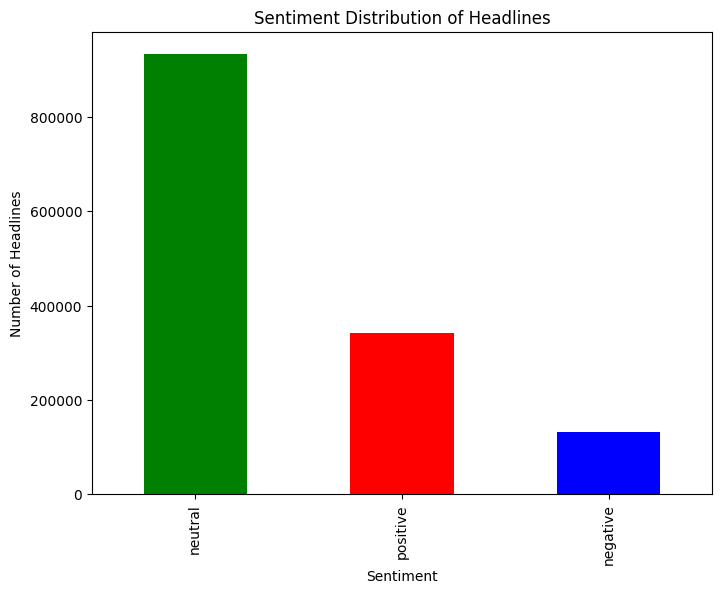


Most Common Words:
[('stocks', 161676), ('vs', 138833), ('eps', 128761), ('shares', 114120), ('reports', 108677), ('est', 107160), ('update', 91643), ('market', 90879), ('earnings', 87063), ('sales', 79475), ('top', 78489), ('benzinga', 74466), ('pt', 73046), ('announces', 66531), ('price', 64205), ('buy', 63910), ('downgrades', 61941), ('trading', 61141), ('raises', 57783), ('upgrades', 56802)]


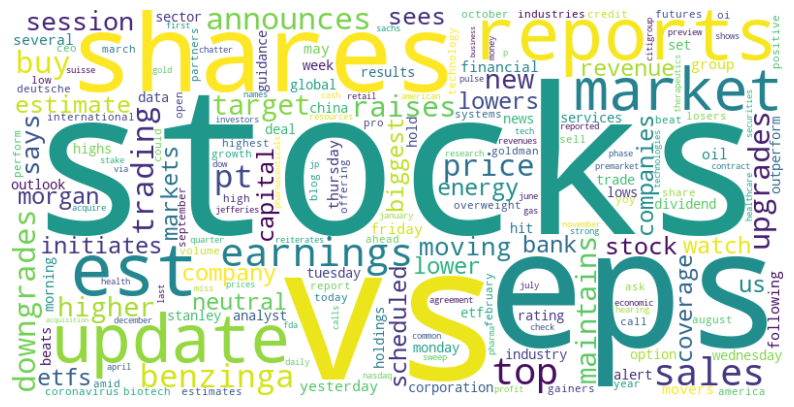


Identified Topics:
(0, '0.082*"vs" + 0.067*"eps" + 0.061*"est" + 0.056*"sales" + 0.052*"reports"')
(1, '0.039*"shares" + 0.023*"update" + 0.022*"retail" + 0.021*"market" + 0.019*"trading"')
(2, '0.028*"earnings" + 0.013*"says" + 0.012*"scheduled" + 0.011*"announces" + 0.009*"yum"')
(3, '0.053*"price" + 0.039*"pt" + 0.031*"buy" + 0.029*"raises" + 0.028*"target"')
(4, '0.057*"stocks" + 0.044*"benzinga" + 0.038*"etfs" + 0.029*"top" + 0.025*"etf"')
Topic 1:
0.082*"vs" + 0.067*"eps" + 0.061*"est" + 0.056*"sales" + 0.052*"reports"


Topic 2:
0.039*"shares" + 0.023*"update" + 0.022*"retail" + 0.021*"market" + 0.019*"trading"


Topic 3:
0.028*"earnings" + 0.013*"says" + 0.012*"scheduled" + 0.011*"announces" + 0.009*"yum"


Topic 4:
0.053*"price" + 0.039*"pt" + 0.031*"buy" + 0.029*"raises" + 0.028*"target"


Topic 5:
0.057*"stocks" + 0.044*"benzinga" + 0.038*"etfs" + 0.029*"top" + 0.025*"etf"




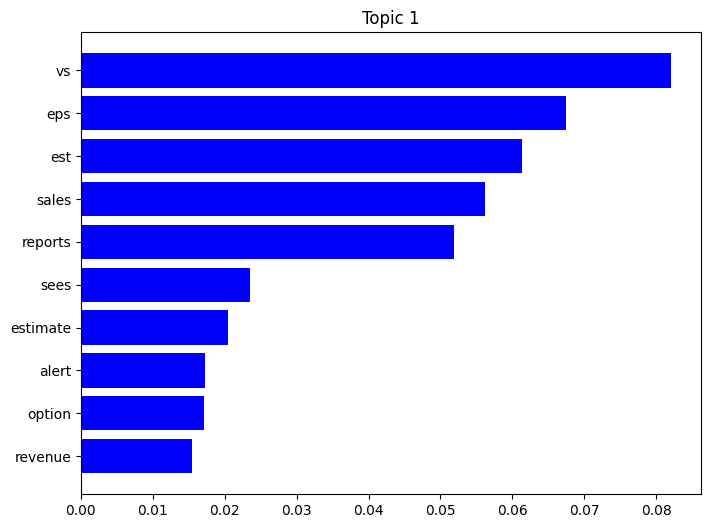

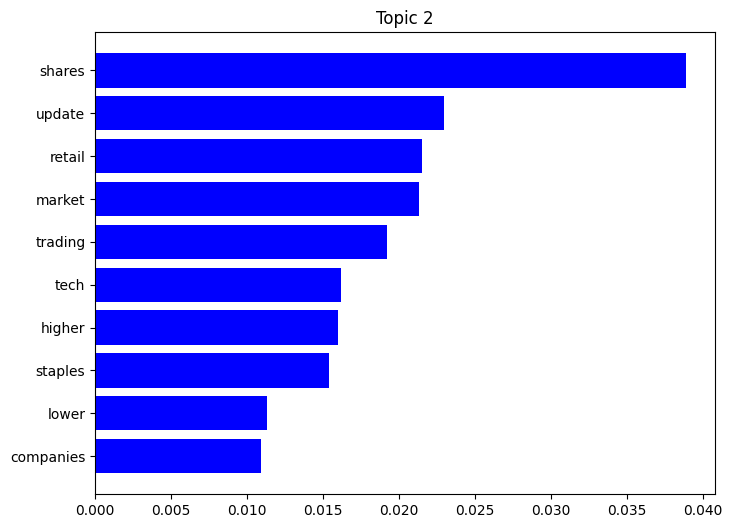

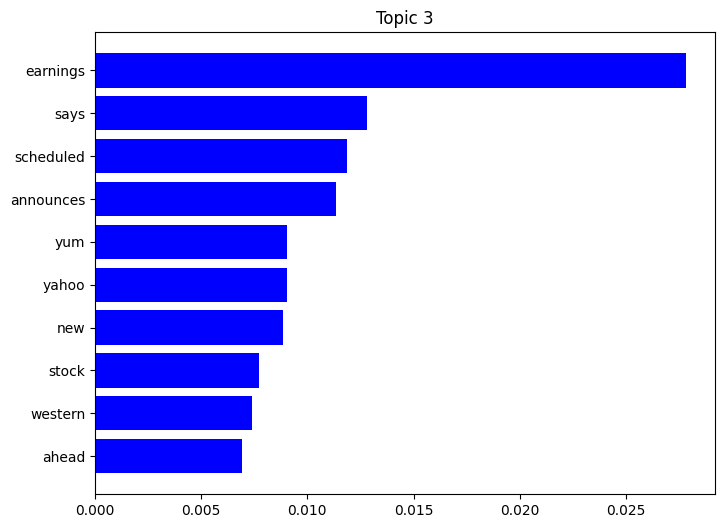

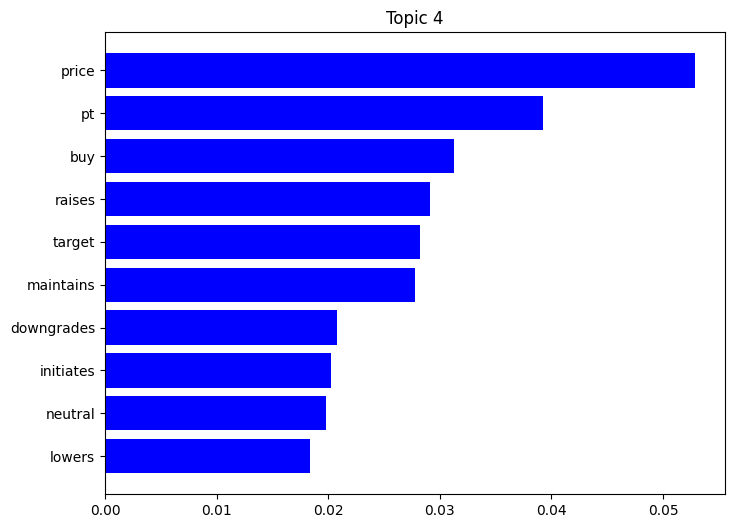

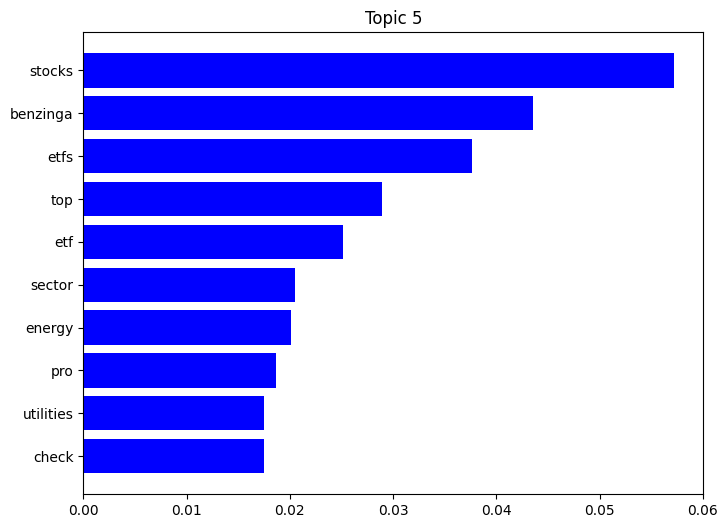

In [4]:
# Task 1: Sentiment Analysis
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

df['sentiment_score'] = df['headline'].apply(get_sentiment)

# Categorize the sentiment into positive, negative, and neutral
df['sentiment'] = df['sentiment_score'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

# Display sentiment distribution
sentiment_distribution = df['sentiment'].value_counts()
print("Sentiment Distribution:")
print(sentiment_distribution)

# Visualize sentiment distribution
plt.figure(figsize=(8, 6))
sentiment_distribution.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Sentiment Distribution of Headlines')
plt.xlabel('Sentiment')
plt.ylabel('Number of Headlines')
plt.show()

# Task 2: Topic Modeling and Keyword Extraction
# Preprocess the text
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text.lower(),language='english', preserve_line=True)
    # Remove stopwords and punctuation
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

df['tokens'] = df['headline'].apply(preprocess_text)

# Create a frequency distribution of the tokens
all_words = [word for tokens in df['tokens'] for word in tokens]
fdist = FreqDist(all_words)
common_words = fdist.most_common(20)
print("\nMost Common Words:")
print(common_words)

# Visualize the most common words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fdist)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Task 3: Topic Modeling using LDA (Latent Dirichlet Allocation)
# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(df['tokens'])
# Create a corpus
corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]

# Train LDA model
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)

# Print the topics
topics = lda_model.print_topics(num_words=5)
print("\nIdentified Topics:")
for topic in topics:
    print(topic)

# Visualizing the topics with their corresponding word distributions
for idx, topic in topics:
    print(f"Topic {idx+1}:")
    print(topic)
    print("\n")

# Visualize topic distributions
for i, topic in lda_model.show_topics(formatted=False, num_topics=5, num_words=10):
    words, weights = zip(*topic)
    plt.figure(figsize=(8, 6))
    plt.barh(words, weights, color='blue')
    plt.title(f'Topic {i+1}')
    plt.gca().invert_yaxis()
    plt.show()


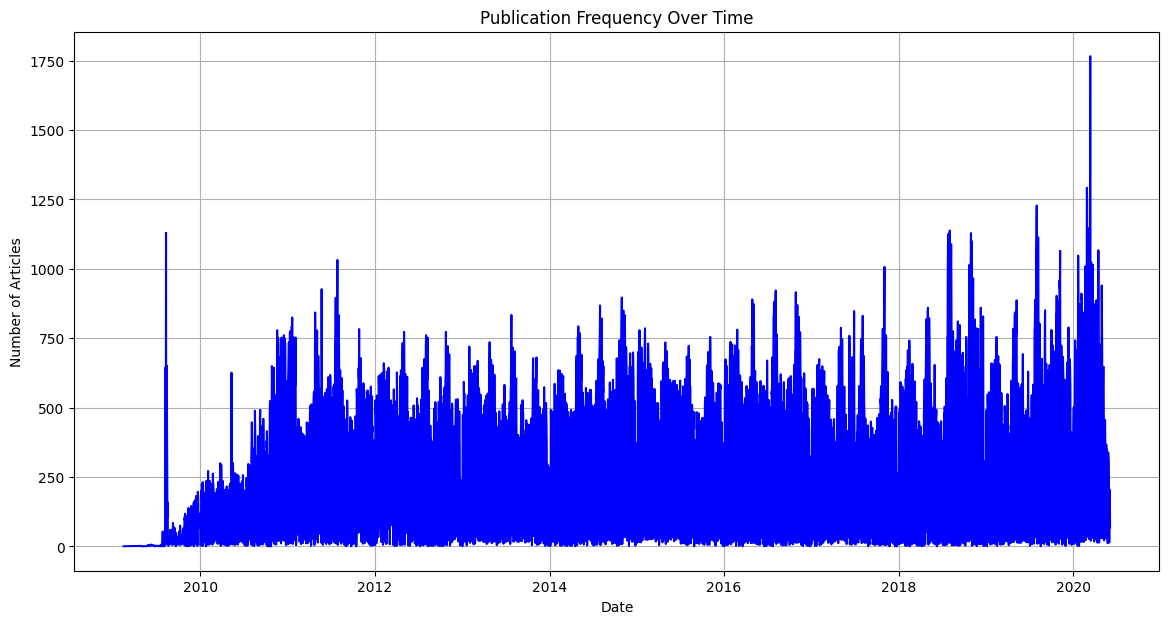

Detected spikes in article publications:
publication_date
2009-06-01      5
2009-06-05      6
2009-06-09      7
2009-07-21      7
2009-07-27     54
             ... 
2020-04-29    940
2020-04-30    839
2020-05-26    339
2020-05-27    320
2020-05-28    304
Length: 941, dtype: int64


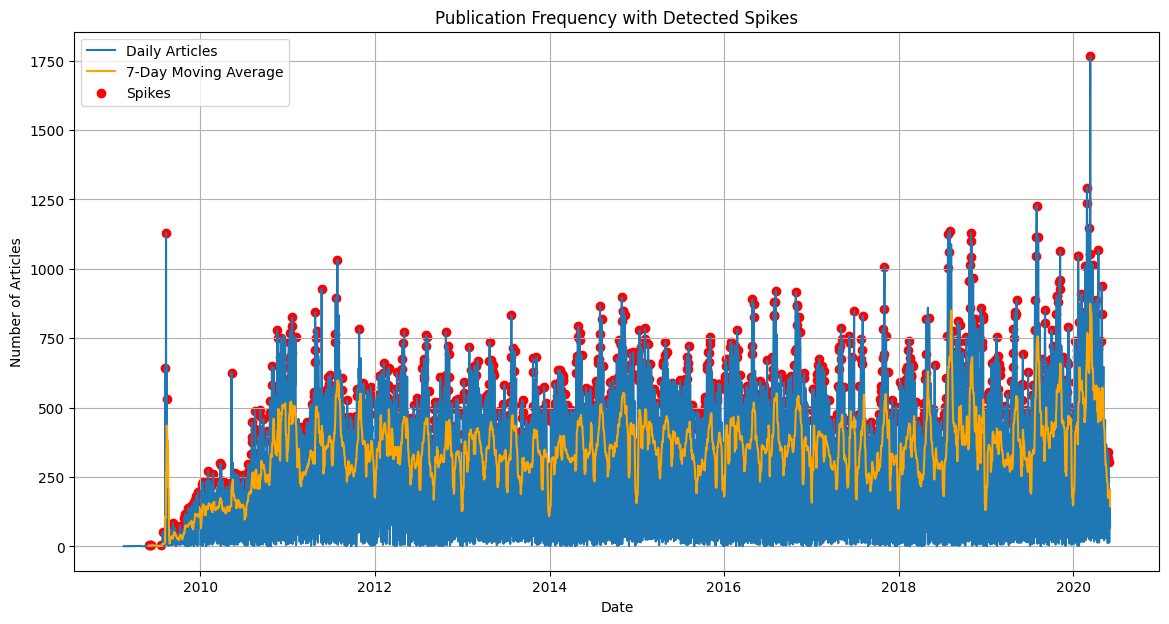

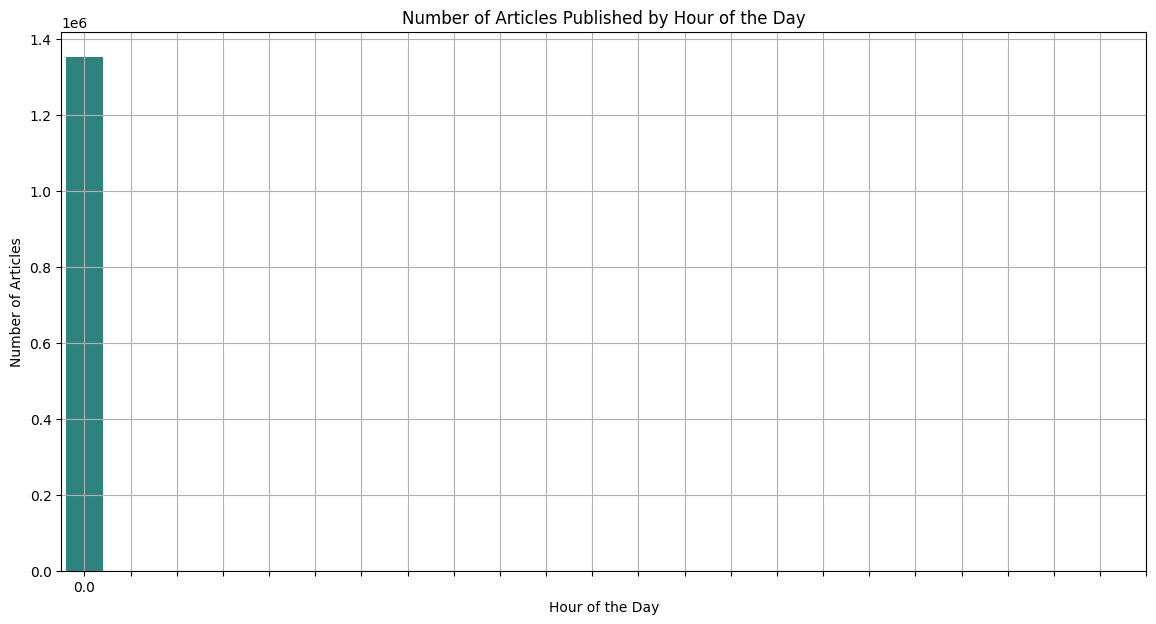

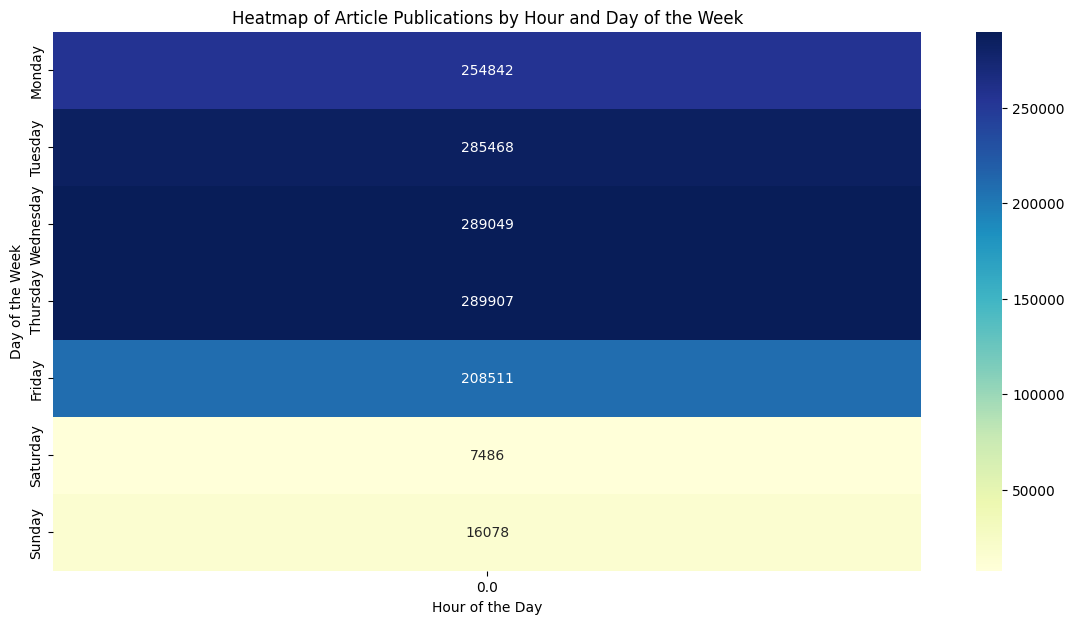

In [13]:
# Convert the date column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Task 1: Publication Frequency Over Time

# Group by date to count the number of articles per day
df['publication_date'] = df['date'].dt.date
articles_per_day = df.groupby('publication_date').size()

# Plotting publication frequency over time
plt.figure(figsize=(14, 7))
articles_per_day.plot(kind='line', color='blue')
plt.title('Publication Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.show()

# Task 2: Detecting Spikes in Article Publications
# To identify spikes, we'll highlight days with article counts that are significantly higher than the moving average.

# Calculate a 7-day moving average
articles_per_day_ma = articles_per_day.rolling(window=7).mean()

# Identify spikes by comparing the actual number of articles to the moving average
spikes = articles_per_day[articles_per_day > 1.5 * articles_per_day_ma]
print("Detected spikes in article publications:")
print(spikes)

# Plot the spikes on top of the original time series
plt.figure(figsize=(14, 7))
plt.plot(articles_per_day, label='Daily Articles')
plt.plot(articles_per_day_ma, label='7-Day Moving Average', color='orange')
plt.scatter(spikes.index, spikes, color='red', label='Spikes')
plt.title('Publication Frequency with Detected Spikes')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.legend()
plt.grid(True)
plt.show()

# Task 3: Analysis of Publishing Times

# Extract the hour from the datetime
df['publication_hour'] = df['date'].dt.hour

# Group by hour to count the number of articles published each hour
articles_per_hour = df.groupby('publication_hour').size()

# Plot the distribution of publishing times
plt.figure(figsize=(14, 7))
sns.barplot(x=articles_per_hour.index, y=articles_per_hour.values, palette='viridis' ,hue=articles_per_hour.index,legend=False)
plt.title('Number of Articles Published by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Articles')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()



# Optional: Heatmap of publication times by hour and day of the week
df['day_of_week'] = df['date'].dt.day_name()
hourly_distribution = df.groupby(['day_of_week', 'publication_hour']).size().unstack().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(14, 7))
sns.heatmap(hourly_distribution, cmap='YlGnBu', annot=True, fmt="d")
plt.title('Heatmap of Article Publications by Hour and Day of the Week')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.show()


# Publisher Analysis
To perform a publisher analysis, we'll focus on the following tasks:

1. **Identify the Most Active Publishers**: Determine which publishers contribute the most to the news feed.
2. **Analyze Differences in News Type**: Explore whether there is a difference in the type of news reported by different publishers.
3. **Unique Domains Analysis**: If publishers are identified by email addresses, extract and analyze the unique domains to see which organizations contribute most frequently.

Top Publishers by Number of Articles:
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


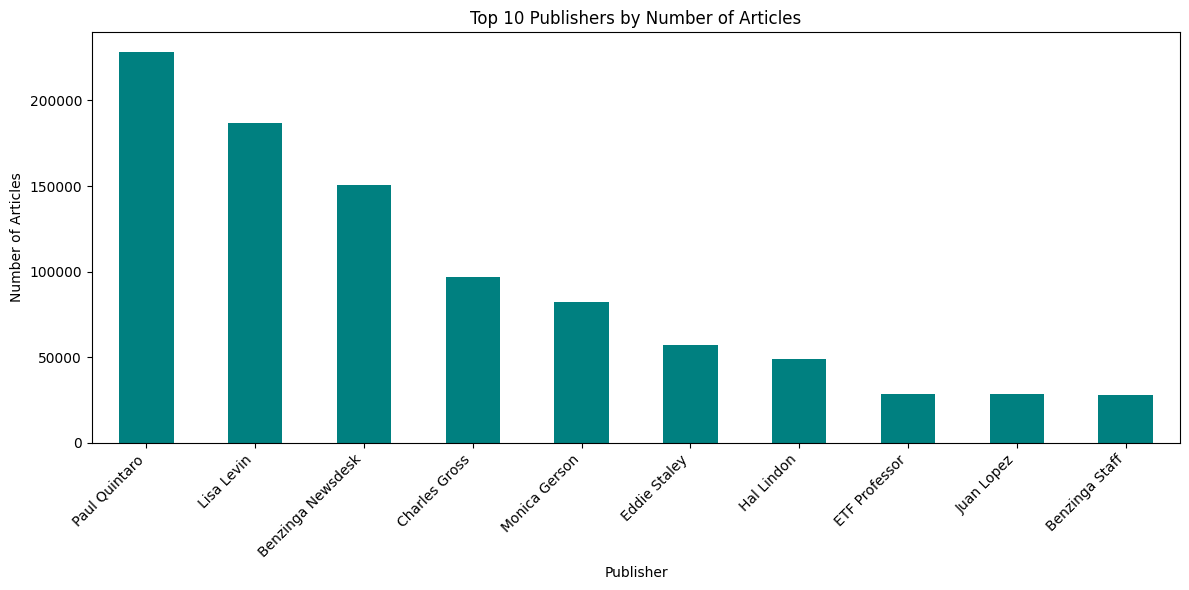


News Type Distribution for Top Publishers:
stock                A   AA  AAC  AADR  AAL  AAMC  AAME  AAN  AAOI  AAON  ...  \
publisher                                                                 ...   
Benzinga Newsdesk   81  109   23     0  229    10     9   42    55    21  ...   
Benzinga Staff     438   76    3     0    0     0     4   11     0     3  ...   
Charles Gross       27  175   12     0    4     2     0   23    18     1  ...   
ETF Professor        0   29    0     2    0     0     0    0     0     0  ...   
Eddie Staley        27   65    5     0   29     1     2   10    17     5  ...   
Hal Lindon          36   72   10     0   10     3     7   18    13     4  ...   
Juan Lopez          33   30    0     0    5     0     0    5     1     0  ...   
Lisa Levin         126  253   57     0    0     6     6   80   114    14  ...   
Monica Gerson       68  216    2     0    0     2     5   21     2    34  ...   
Paul Quintaro      127  297   41     0   98    12    14   98    8

<Figure size 1200x600 with 0 Axes>

ValueError: Image size of 735x128170 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>


Top Domains by Number of Articles:
domain
benzinga.com              7937
gmail.com                  139
andyswan.com                 5
investdiva.com               2
tothetick.com                2
eosdetroit.io                1
forextraininggroup.com       1
stockmetrix.net              1
Name: count, dtype: int64


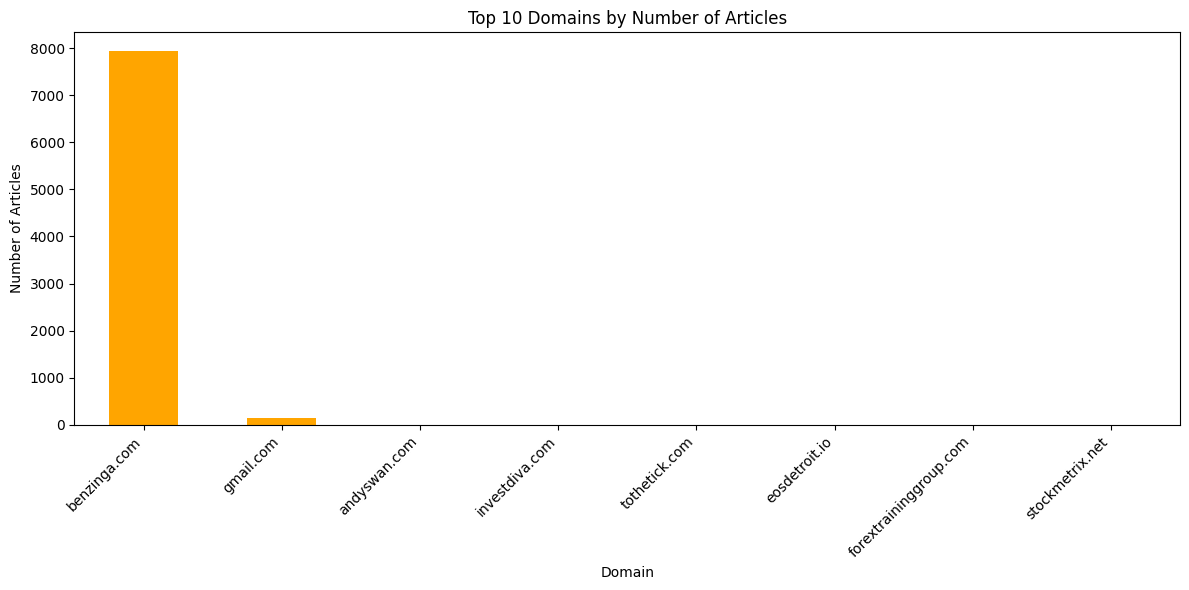

In [5]:

# Task 1: Identify the Most Active Publishers
publisher_counts = df['publisher'].value_counts()

# Limit to top 10 publishers to avoid excessive data points
top_publishers = publisher_counts.head(10)
print("Top Publishers by Number of Articles:")
print(top_publishers)

# Visualize the most active publishers with limited categories
plt.figure(figsize=(12, 6))  # Ensure the figure size is manageable
top_publishers.plot(kind='bar', color='teal')
plt.title('Top 10 Publishers by Number of Articles')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()  # Adjusts plot to fit within the figure area
plt.show()

# Task 2: Analyze Differences in News Type
# Assuming 'stock' column indicates the type of news or related stock symbol
# Limit to top 5 publishers
top_publishers_list = top_publishers.index

# Filter the dataframe to include only top publishers
df_top_publishers = df[df['publisher'].isin(top_publishers_list)]

# Pivot table to see the count of different news types per publisher
news_type_distribution = pd.pivot_table(df_top_publishers, values='headline', index='publisher', 
                                        columns='stock', aggfunc='count', fill_value=0)

print("\nNews Type Distribution for Top Publishers:")
print(news_type_distribution)

# Visualize the distribution of news types by top publishers
plt.figure(figsize=(12, 6))  # Ensure the figure size is appropriate
news_type_distribution.plot(kind='bar', stacked=True, colormap='tab20c')
plt.title('Distribution of News Types by Top 5 Publishers')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha="right")
plt.legend(title='Stock', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()  # Adjusts plot to fit within the figure area
plt.show()

# Task 3: Unique Domains Analysis from Email Addresses
def extract_domain(email):
    # Use regex to extract domain from email addresses
    match = re.search(r'@([\w.-]+)', email)
    return match.group(1) if match else None

# Extract domain names from publisher names
df['domain'] = df['publisher'].apply(extract_domain)

# Count the occurrences of each domain
domain_counts = df['domain'].value_counts()

# Limit to top 10 domains to avoid excessive data points
top_domains = domain_counts.head(10)
print("\nTop Domains by Number of Articles:")
print(top_domains)

# Visualize the top domains
plt.figure(figsize=(12, 6))  # Ensure the figure size is manageable
top_domains.plot(kind='bar', color='orange')
plt.title('Top 10 Domains by Number of Articles')
plt.xlabel('Domain')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()  # Adjusts plot to fit within the figure area
plt.show()



### Explanation of the Code:

1. **Identify the Most Active Publishers**:
   - **Counting Articles**: The script uses `value_counts()` to count the number of articles contributed by each publisher.
   - **Visualization**: The top 10 publishers are visualized using a bar chart.

2. **Analyze Differences in News Type**:
   - **Pivot Table**: A pivot table is created to analyze how different publishers contribute to different types of news. Here, we assume that the 'stock' column represents different news types or related stock symbols.
   - **Stacked Bar Chart**: The distribution of news types for the top 5 publishers is visualized using a stacked bar chart.

3. **Unique Domains Analysis**:
   - **Domain Extraction**: A regular expression is used to extract domains from publisher names, assuming they might be email addresses.
   - **Counting Domains**: The script counts the occurrences of each domain to identify which organizations contribute the most.
   - **Visualization**: The top 10 domains are visualized using a bar chart.

### Next Steps:
- **Deeper Analysis**: You could perform more granular analysis on specific publishers or domains to understand their impact on the news feed.
- **Content Analysis**: If there is text data available, you can analyze the sentiment or topics associated with different publishers or domains.
- **Time Series Correlation**: Analyze if certain publishers are more active during specific market events.

Would you like to refine this analysis further or explore another aspect?


News Type Distribution for Top Publishers:
stock                A   AA  AAC  AADR  AAL  AAMC  AAME  AAN  AAOI  AAON  ...  \
publisher                                                                 ...   
Benzinga Newsdesk   81  109   23     0  229    10     9   42    55    21  ...   
Benzinga Staff     438   76    3     0    0     0     4   11     0     3  ...   
Charles Gross       27  175   12     0    4     2     0   23    18     1  ...   
ETF Professor        0   29    0     2    0     0     0    0     0     0  ...   
Eddie Staley        27   65    5     0   29     1     2   10    17     5  ...   
Hal Lindon          36   72   10     0   10     3     7   18    13     4  ...   
Juan Lopez          33   30    0     0    5     0     0    5     1     0  ...   
Lisa Levin         126  253   57     0    0     6     6   80   114    14  ...   
Monica Gerson       68  216    2     0    0     2     5   21     2    34  ...   
Paul Quintaro      127  297   41     0   98    12    14   98    8

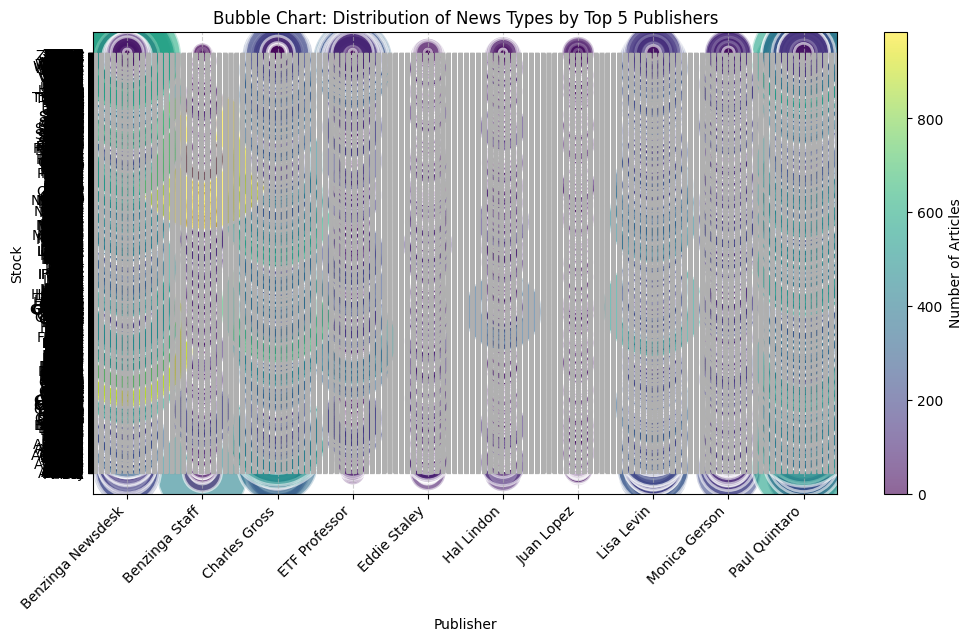

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have your dataframe `df` and `top_publishers` prepared

# Limit to top 5 publishers
top_publishers_list = top_publishers.index

# Filter the dataframe to include only top publishers
df_top_publishers = df[df['publisher'].isin(top_publishers_list)]

# Pivot table to see the count of different news types per publisher
news_type_distribution = pd.pivot_table(df_top_publishers, values='headline', index='publisher', 
                                        columns='stock', aggfunc='count', fill_value=0)

print("\nNews Type Distribution for Top Publishers:")
print(news_type_distribution)

# Convert pivot table to a flat dataframe for bubble chart
flat_df = news_type_distribution.reset_index().melt(id_vars='publisher', var_name='stock', value_name='count')

# Bubble Chart
plt.figure(figsize=(12, 6))
bubble_chart = plt.scatter(
    x=flat_df['publisher'], 
    y=flat_df['stock'], 
    s=flat_df['count'] * 10,  # Adjust bubble size by multiplying count
    alpha=0.6, 
    edgecolors="w", 
    linewidth=2,
    c=flat_df['count'],  # Optional: color by count
    cmap='viridis'  # Optional: color map
)

# Adding labels and a color bar
plt.title('Bubble Chart: Distribution of News Types by Top 5 Publishers')
plt.xlabel('Publisher')
plt.ylabel('Stock')
plt.xticks(rotation=45, ha="right")
plt.colorbar(bubble_chart, label='Number of Articles')  # Optional: color bar indicating the number of articles
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from pywaffle import Waffle
import matplotlib.cm as cm

# Waffle Plot
# Calculate the total number of articles for each publisher
total_articles_per_publisher = news_type_distribution.sum(axis=1)

# Normalize the counts to percentages for the waffle plot
normalized_distribution = (news_type_distribution.T / total_articles_per_publisher).T * 100

# Convert the normalized distribution to a flat format suitable for the waffle plot
waffle_data = {}
for publisher in normalized_distribution.index:
    for stock, percentage in normalized_distribution.loc[publisher].items():
        waffle_data[f"{publisher}-{stock}"] = percentage

# Generate a color map with enough colors for each unique category
unique_categories = len(waffle_data)
color_map = cm.get_cmap('tab20c', unique_categories)  # 'tab20c' can be replaced with any colormap

# Convert colormap to list of colors
colors = [color_map(i) for i in range(unique_categories)]

# Waffle plot
fig = plt.figure(
    FigureClass=Waffle, 
    rows=15, 
    values=waffle_data, 
    colors=colors, 
    title={'label': 'Waffle Plot: Distribution of News Types by Top 5 Publishers', 'loc': 'center'},
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)}
)
plt.show()


### Explanation:
2. **Technical Indicators Calculation**: The `calculate_indicators` function computes the 20-day and 50-day Simple Moving Averages (SMA), RSI, and MACD using the `talib` library.

3. **Financial Metrics Calculation**: The `calculate_financial_metrics` function uses PyNance's TA class to calculate additional financial metrics like volatility and momentum.

4. **Data Visualization**: The `visualize_data` function creates multiple plots:
   - Closing price with 20-day and 50-day SMAs.
   - RSI with overbought and oversold levels.
   - MACD, MACD signal, and MACD histogram.

C:\Users\MSI\AppData\Local\Temp\ipykernel_12276\3267108290.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\MSI\AppData\Local\Temp\ipykernel_12276\3267108290.py:91: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(os.path.join(output_folder, filename + '_macd.png'))
c:\Users\MSI\.conda\envs\solar_radiation\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


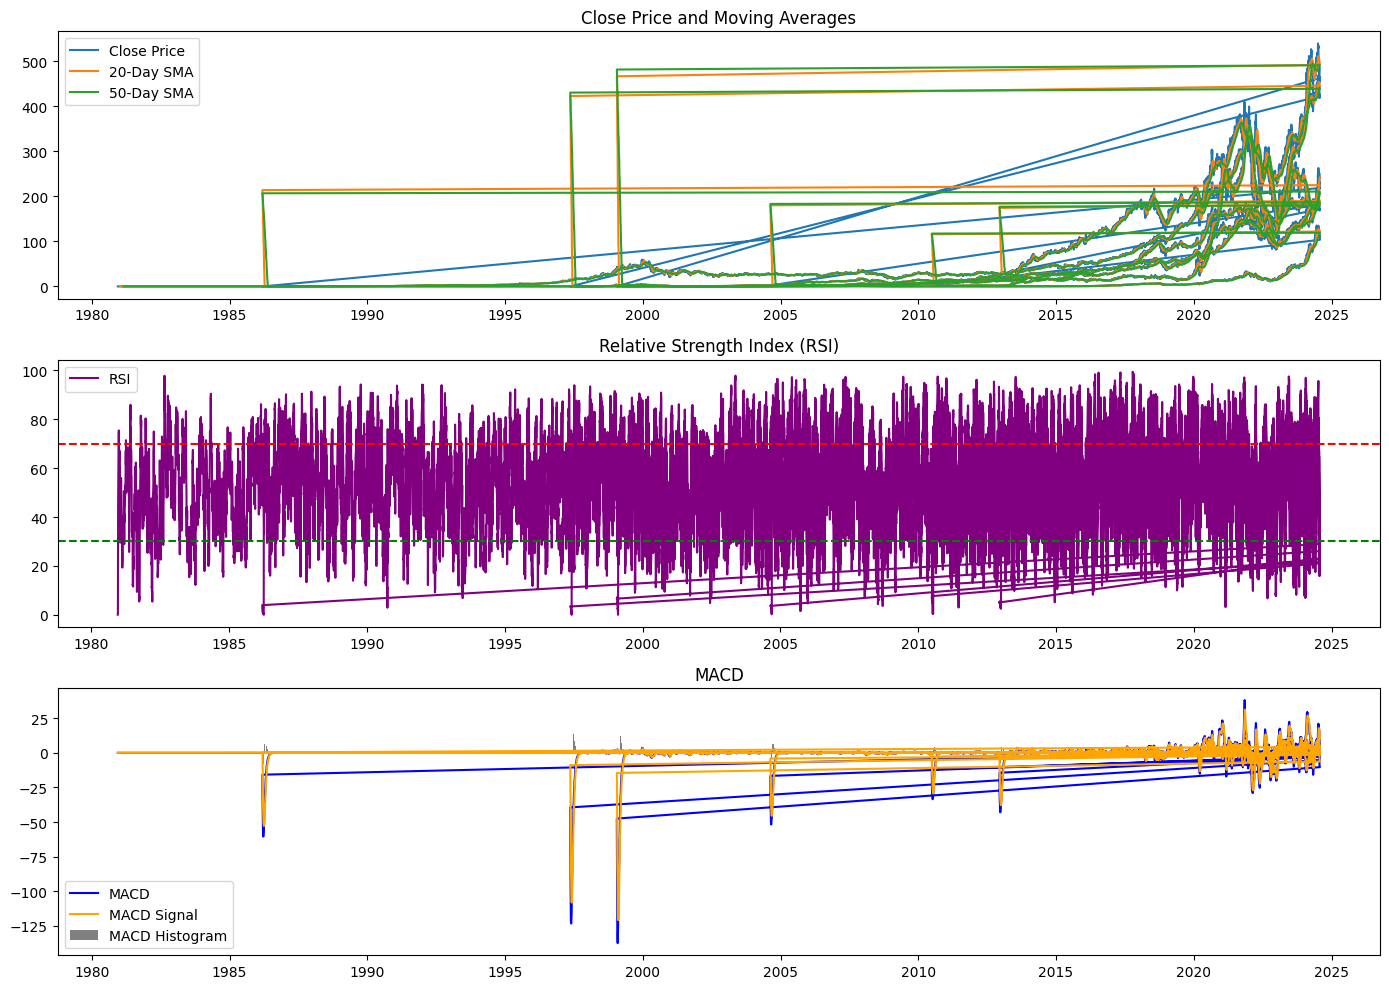

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load and Prepare the Data
def load_data(file_paths):
    data_frames = []
    for file in file_paths:
        df = pd.read_csv(file)
        df['Date'] = pd.to_datetime(df['Date'])
        data_frames.append(df)
    combined_df = pd.concat(data_frames, ignore_index=True)
    return combined_df

file_paths = [r'C:\Users\MSI\Documents\start\Financial_News_and_Stock_Price_Integration_Dataset_Analysist\dataset\AAPL_historical_data.csv', r'C:\Users\MSI\Documents\start\Financial_News_and_Stock_Price_Integration_Dataset_Analysist\dataset\MSFT_historical_data.csv', r'C:\Users\MSI\Documents\start\Financial_News_and_Stock_Price_Integration_Dataset_Analysist\dataset\AMZN_historical_data.csv', r'C:\Users\MSI\Documents\start\Financial_News_and_Stock_Price_Integration_Dataset_Analysist\dataset\GOOG_historical_data.csv', r'C:\Users\MSI\Documents\start\Financial_News_and_Stock_Price_Integration_Dataset_Analysist\dataset\META_historical_data.csv', r'C:\Users\MSI\Documents\start\Financial_News_and_Stock_Price_Integration_Dataset_Analysist\dataset\NVDA_historical_data.csv', r'C:\Users\MSI\Documents\start\Financial_News_and_Stock_Price_Integration_Dataset_Analysist\dataset\TSLA_historical_data.csv']

stock_data = load_data(file_paths)

# 2. Calculate Basic Technical Indicators
def calculate_sma(data, period):
    return data.rolling(window=period).mean()

def calculate_rsi(data, period=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    short_ema = data.ewm(span=short_period, adjust=False).mean()
    long_ema = data.ewm(span=long_period, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    histogram = macd - signal
    return macd, signal, histogram

stock_data['SMA_20'] = calculate_sma(stock_data['Close'], period=20)
stock_data['SMA_50'] = calculate_sma(stock_data['Close'], period=50)
stock_data['RSI'] = calculate_rsi(stock_data['Close'], period=14)
stock_data['MACD'], stock_data['MACD_signal'], stock_data['MACD_hist'] = calculate_macd(stock_data['Close'])

# 3. Calculate Financial Metrics using PyNance (Optional, not implemented due to lack of PyNance support)
# This part is left for integration as per actual availability of financial metrics tools.

# 4. Visualize the Data and Save Visualizations
output_folder = r'C:\Users\MSI\Documents\start\Financial_News_and_Stock_Price_Integration_Dataset_Analysist\analysis\graphs\visualizations'

os.makedirs(output_folder, exist_ok=True)

def save_visualization(df, output_folder, filename):
    plt.figure(figsize=(14, 10))
    
    # Plot Closing Price with Moving Averages
    plt.subplot(3, 1, 1)
    plt.plot(df['Date'], df['Close'], label='Close Price')
    plt.plot(df['Date'], df['SMA_20'], label='20-Day SMA')
    plt.plot(df['Date'], df['SMA_50'], label='50-Day SMA')
    plt.title('Close Price and Moving Averages')
    plt.legend()
    
    # Save the plot
    plt.savefig(os.path.join(output_folder, filename + '_price_sma.png'))

    
    # Plot RSI
    plt.subplot(3, 1, 2)
    plt.plot(df['Date'], df['RSI'], label='RSI', color='purple')
    plt.axhline(70, color='red', linestyle='--')
    plt.axhline(30, color='green', linestyle='--')
    plt.title('Relative Strength Index (RSI)')
    plt.legend()
    
    plt.savefig(os.path.join(output_folder, filename + '_rsi.png'))
    
    
    # Plot MACD
    plt.subplot(3, 1, 3)
    plt.plot(df['Date'], df['MACD'], label='MACD', color='blue')
    plt.plot(df['Date'], df['MACD_signal'], label='MACD Signal', color='orange')
    plt.bar(df['Date'], df['MACD_hist'], label='MACD Histogram', color='grey')
    plt.title('MACD')
    plt.legend()
    
    plt.tight_layout()
    # Save the plot
    plt.savefig(os.path.join(output_folder, filename + '_macd.png'))
    
    plt.show()

save_visualization(stock_data, output_folder, 'stock_analysis')


### Explanation of Each Advanced Analysis:

1. **Volatility Analysis Over Time**:
   - **Purpose**: This analysis calculates the stock's volatility, which is a measure of how much the stock's price fluctuates over time. Higher volatility often indicates higher risk.
   - **Method**: Volatility is measured using the rolling standard deviation of the stock's closing price over different periods (20-day and 50-day).

2. **Correlation Analysis**:
   - **Purpose**: Correlation analysis helps determine the relationship between different technical indicators (like SMA, RSI, MACD) and the stock's closing price.
   - **Method**: A correlation matrix is calculated and visualized using a heatmap to show how closely related each indicator is to the stock price.

3. **Seasonal Trend Analysis**:
   - **Purpose**: This analysis seeks to identify seasonal patterns in stock prices, such as higher average prices during certain months.
   - **Method**: The average closing price is calculated for each month, and a bar chart is used to visualize these seasonal trends.

4. **Backtesting a Simple Moving Average Strategy**:
   - **Purpose**: Backtesting evaluates how a simple moving average trading strategy would have performed historically. The strategy involves buying when a short-term SMA crosses above a long-term SMA and selling when it crosses below.
   - **Method**: The cumulative returns from the strategy are compared to the market returns to assess the strategy's effectiveness.

5. **Comparative Analysis Across Different Stocks or Indices**:
   - **Purpose**: This analysis compares the performance of technical indicators across different stocks or indices to see how they behave under different market conditions.
   - **Method**: The 20-day SMA for each stock is plotted on the same graph to visualize the differences and similarities in trends.

In [12]:


# Function to ensure the output directory exists
def create_output_directory(directory_name):
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)

output_folder = r'C:\Users\MSI\Documents\start\Financial_News_and_Stock_Price_Integration_Dataset_Analysist\analysis\graphs\advanced_analyses_visualizations'
file_paths = [r'C:\Users\MSI\Documents\start\Financial_News_and_Stock_Price_Integration_Dataset_Analysist\dataset\AAPL_historical_data.csv', r'C:\Users\MSI\Documents\start\Financial_News_and_Stock_Price_Integration_Dataset_Analysist\dataset\MSFT_historical_data.csv', r'C:\Users\MSI\Documents\start\Financial_News_and_Stock_Price_Integration_Dataset_Analysist\dataset\AMZN_historical_data.csv', r'C:\Users\MSI\Documents\start\Financial_News_and_Stock_Price_Integration_Dataset_Analysist\dataset\GOOG_historical_data.csv', r'C:\Users\MSI\Documents\start\Financial_News_and_Stock_Price_Integration_Dataset_Analysist\dataset\META_historical_data.csv', r'C:\Users\MSI\Documents\start\Financial_News_and_Stock_Price_Integration_Dataset_Analysist\dataset\NVDA_historical_data.csv', r'C:\Users\MSI\Documents\start\Financial_News_and_Stock_Price_Integration_Dataset_Analysist\dataset\TSLA_historical_data.csv']

# output_folder = 'advanced_analyses_visualizations'
create_output_directory(output_folder)

# Load the stock data
def load_data(file_paths):
    data_frames = []
    for file in file_paths:
        df = pd.read_csv(file)
        df['Date'] = pd.to_datetime(df['Date'])
        data_frames.append(df)
    combined_df = pd.concat(data_frames, ignore_index=True)
    return combined_df

# Example file paths, replace these with actual paths
# file_paths = ['file1.csv', 'file2.csv', 'file3.csv', 'file4.csv', 'file5.csv', 'file6.csv', 'file7.csv']
stock_data = load_data(file_paths)

# Utility Functions to Calculate Indicators
def calculate_sma(data, period):
    return data.rolling(window=period).mean()

def calculate_rsi(data, period=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    short_ema = data.ewm(span=short_period, adjust=False).mean()
    long_ema = data.ewm(span=long_period, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    histogram = macd - signal
    return macd, signal, histogram

# Calculate Indicators for the Stock Data
stock_data['SMA_20'] = calculate_sma(stock_data['Close'], period=20)
stock_data['SMA_50'] = calculate_sma(stock_data['Close'], period=50)
stock_data['RSI'] = calculate_rsi(stock_data['Close'], period=14)
stock_data['MACD'], stock_data['MACD_signal'], stock_data['MACD_hist'] = calculate_macd(stock_data['Close'])

# 1. Volatility Analysis Over Time
def volatility_analysis(df):
    """
    Volatility Analysis: This analysis calculates the volatility of the stock over a specific period.
    Volatility is a statistical measure of the dispersion of returns for a given security or market index.
    It is often used to quantify the risk of the stock.

    Here, we calculate the rolling standard deviation of the stock's closing price to measure volatility.
    """
    df['Volatility_20'] = df['Close'].rolling(window=20).std()  # 20-day rolling volatility
    df['Volatility_50'] = df['Close'].rolling(window=50).std()  # 50-day rolling volatility

    plt.figure(figsize=(10, 6))
    plt.plot(df['Date'], df['Volatility_20'], label='20-Day Volatility')
    plt.plot(df['Date'], df['Volatility_50'], label='50-Day Volatility')
    plt.title('Volatility Over Time')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'volatility_analysis.png'))
    plt.close()

volatility_analysis(stock_data)

# 2. Correlation Analysis
def correlation_analysis(df):
    """
    Correlation Analysis: This analysis examines the relationship between different technical indicators and the stock price.
    By calculating the correlation coefficients, we can understand how closely related these indicators are to the stock price.
    """
    indicators = ['Close', 'SMA_20', 'SMA_50', 'RSI', 'MACD']
    correlation_data = df[indicators].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_data, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Analysis Between Indicators and Stock Price')
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'correlation_analysis.png'))
    plt.close()

correlation_analysis(stock_data)

# 3. Seasonal Trend Analysis
def seasonal_trend_analysis(df):
    """
    Seasonal Trend Analysis: This analysis identifies seasonal patterns in the stock prices.
    For instance, some stocks may exhibit higher returns during certain months or quarters of the year.
    """
    df['Month'] = df['Date'].dt.month
    monthly_avg = df.groupby('Month')['Close'].mean()

    plt.figure(figsize=(10, 6))
    monthly_avg.plot(kind='bar', color='skyblue')
    plt.title('Seasonal Trend Analysis (Average Monthly Closing Price)')
    plt.xlabel('Month')
    plt.ylabel('Average Closing Price')
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'seasonal_trend_analysis.png'))
    plt.close()

seasonal_trend_analysis(stock_data)

# 4. Backtesting a Simple Moving Average Strategy
def backtesting(df):
    """
    Backtesting: This analysis tests a simple trading strategy using moving averages.
    The strategy is: Buy when the 20-day SMA crosses above the 50-day SMA, and sell when it crosses below.
    """
    df['Position'] = np.where(df['SMA_20'] > df['SMA_50'], 1, -1)
    df['Daily_Return'] = df['Close'].pct_change()
    df['Strategy_Return'] = df['Position'].shift(1) * df['Daily_Return']

    plt.figure(figsize=(10, 6))
    plt.plot(df['Date'], df['Strategy_Return'].cumsum(), label='Strategy Cumulative Returns')
    plt.plot(df['Date'], df['Daily_Return'].cumsum(), label='Market Cumulative Returns')
    plt.title('Backtesting a Simple Moving Average Strategy')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'backtesting.png'))
    plt.close()

backtesting(stock_data)

# 5. Comparative Analysis Across Different Stocks or Indices
def comparative_analysis(df_list, labels):
    """
    Comparative Analysis: This analysis compares the performance of technical indicators across different stocks or indices.
    It allows for a broader perspective on how these indicators behave in different market conditions.
    """
    plt.figure(figsize=(10, 6))

    for df, label in zip(df_list, labels):
        df['SMA_20'] = calculate_sma(df['Close'], period=20)
        plt.plot(df['Date'], df['SMA_20'], label=f'{label} 20-Day SMA')

    plt.title('Comparative Analysis of 20-Day SMA Across Different Stocks')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'comparative_analysis.png'))
    plt.close()

# Example comparative analysis with different stock data (using the same data for demonstration)
# In a real scenario, load different datasets for comparison.
comparative_analysis([stock_data, stock_data], ['Stock A', 'Stock B'])

# Final Message
print(f"All analyses have been completed and visualizations have been saved in the '{output_folder}' folder.")


All analyses have been completed and visualizations have been saved in the 'C:\Users\MSI\Documents\start\Financial_News_and_Stock_Price_Integration_Dataset_Analysist\analysis\graphs\advanced_analyses_visualizations' folder.


To perform the correlation analysis between news sentiment and stock movement, given your 6 stock files and 1 raw news data file, we will follow these steps:

1. **Load and Combine the Stock Data**: Combine the six stock files into a single DataFrame.
2. **Load and Prepare the News Data**: Load the raw news data, perform sentiment analysis on the headlines, and align it with the stock data based on dates.
3. **Normalize Dates and Align Datasets**: Ensure that both datasets are aligned by date.
4. **Calculate Stock Returns**: Compute the daily percentage change in stock prices.
5. **Correlation Analysis**: Determine the correlation between news sentiment and stock returns.
6. **Visualize the Results**: Save and display the visualizations.

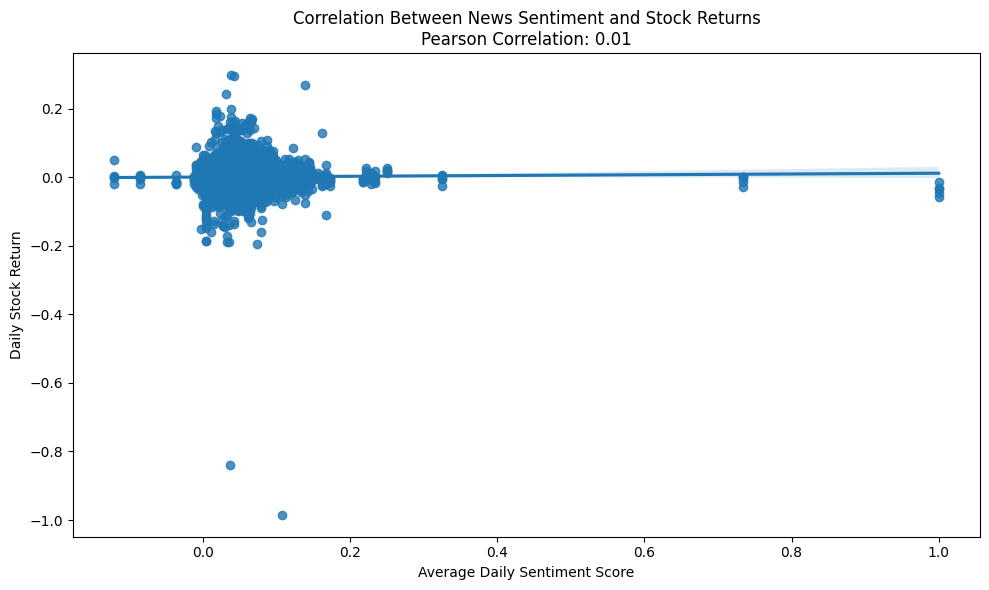

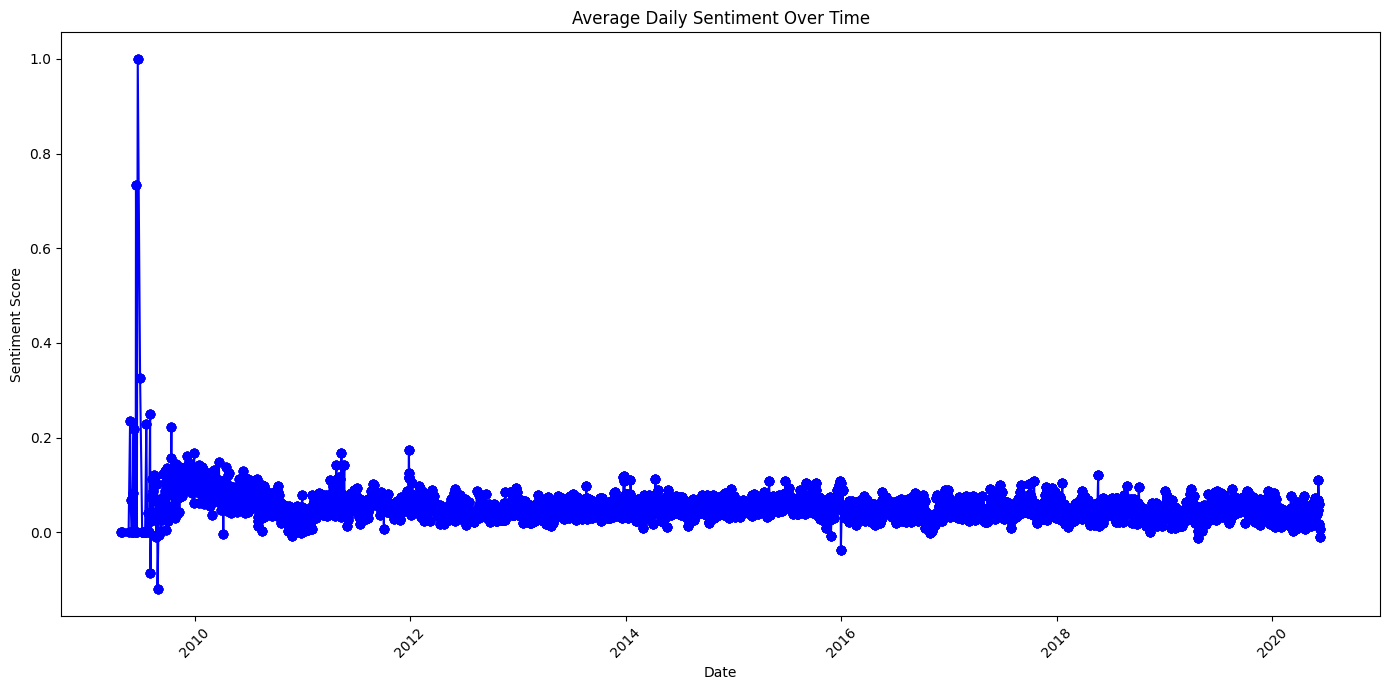

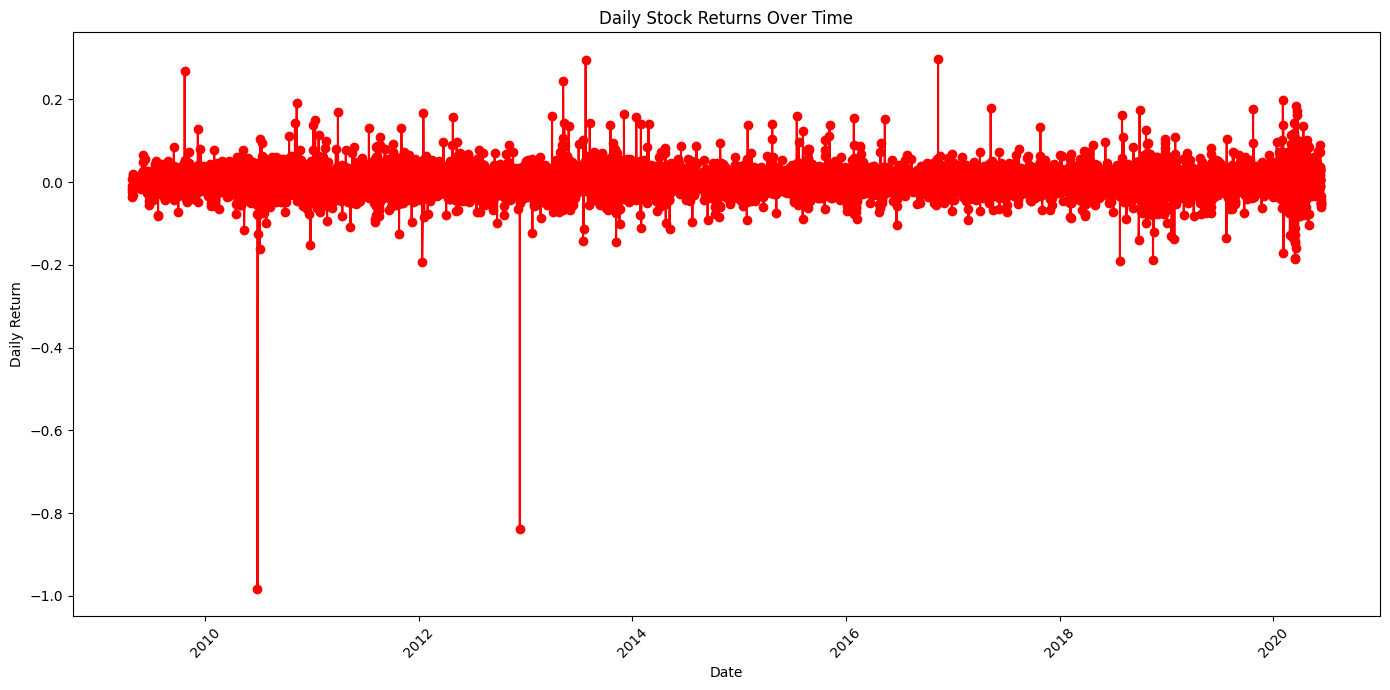

All analyses have been completed and visualizations have been saved in the 'C:\Users\MSI\Documents\start\Financial_News_and_Stock_Price_Integration_Dataset_Analysist\analysis\graphs\news_stock_correlation_visualizations' folder.


In [19]:
import os
import pandas as pd
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Create output directory
output_folder = r'C:\Users\MSI\Documents\start\Financial_News_and_Stock_Price_Integration_Dataset_Analysist\analysis\graphs\news_stock_correlation_visualizations'
stock_file_paths = [r'C:\Users\MSI\Documents\start\Financial_News_and_Stock_Price_Integration_Dataset_Analysist\dataset\AAPL_historical_data.csv', r'C:\Users\MSI\Documents\start\Financial_News_and_Stock_Price_Integration_Dataset_Analysist\dataset\MSFT_historical_data.csv', r'C:\Users\MSI\Documents\start\Financial_News_and_Stock_Price_Integration_Dataset_Analysist\dataset\AMZN_historical_data.csv', r'C:\Users\MSI\Documents\start\Financial_News_and_Stock_Price_Integration_Dataset_Analysist\dataset\GOOG_historical_data.csv', r'C:\Users\MSI\Documents\start\Financial_News_and_Stock_Price_Integration_Dataset_Analysist\dataset\META_historical_data.csv', r'C:\Users\MSI\Documents\start\Financial_News_and_Stock_Price_Integration_Dataset_Analysist\dataset\NVDA_historical_data.csv', r'C:\Users\MSI\Documents\start\Financial_News_and_Stock_Price_Integration_Dataset_Analysist\dataset\TSLA_historical_data.csv']
news_file_path = r'C:\Users\MSI\Documents\start\Financial_News_and_Stock_Price_Integration_Dataset_Analysist\dataset\raw_analyst_ratings.csv'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 1. Load and Combine the Stock Data
def load_and_combine_stock_data(file_paths):
    stock_frames = []
    for file in file_paths:
        df = pd.read_csv(file)
        df['Date'] = pd.to_datetime(df['Date']).dt.date
        stock_frames.append(df)
    combined_stock_df = pd.concat(stock_frames, ignore_index=True)
    return combined_stock_df

# Replace with your actual file paths
# stock_file_paths = ['stock1.csv', 'stock2.csv', 'stock3.csv', 'stock4.csv', 'stock5.csv', 'stock6.csv']
combined_stock_df = load_and_combine_stock_data(stock_file_paths)

# 2. Custom Date Parsing Function
def parse_date(date_str):
    """
    Attempt to parse the date string with common formats, stripping any timezone info.
    """
    try:
        # Try parsing with common datetime format (ISO, etc.)
        return pd.to_datetime(date_str).tz_localize(None)
    except ValueError:
        # Fallback to manual parsing or other formats if needed
        try:
            return pd.to_datetime(date_str, format='%Y-%m-%d %H:%M:%S').tz_localize(None)
        except ValueError:
            # If parsing fails, log or handle the error
            print(f"Failed to parse date: {date_str}")
            return pd.NaT  # Return NaT (Not a Time) for invalid dates

# 3. Load and Prepare the News Data
def load_and_prepare_news_data(news_file):
    news_df = pd.read_csv(news_file)
    # Use the custom parse_date function to handle the date parsing
    news_df['date'] = news_df['date'].apply(parse_date).dt.date
    # Perform sentiment analysis
    news_df['sentiment'] = news_df['headline'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return news_df

# Replace with your actual news file path
# news_file_path = 'news_data.csv'
news_df = load_and_prepare_news_data(news_file_path)

# 4. Aggregate Sentiment by Date
def aggregate_sentiment_by_date(news_df):
    return news_df.groupby('date')['sentiment'].mean().reset_index()

daily_sentiment_df = aggregate_sentiment_by_date(news_df)

# 5. Calculate Stock Returns
def calculate_daily_returns(stock_df):
    stock_df['Daily_Return'] = stock_df['Close'].pct_change()
    return stock_df

combined_stock_df = calculate_daily_returns(combined_stock_df)

# 6. Merge Sentiment and Stock Data
def merge_datasets(sentiment_df, stock_df):
    merged_df = pd.merge(sentiment_df, stock_df[['Date', 'Daily_Return']], left_on='date', right_on='Date', how='inner')
    return merged_df

merged_df = merge_datasets(daily_sentiment_df, combined_stock_df)

# 7. Correlation Analysis
def correlation_analysis(merged_df):
    correlation = merged_df['sentiment'].corr(merged_df['Daily_Return'])
    
    plt.figure(figsize=(10, 6))
    sns.regplot(x=merged_df['sentiment'], y=merged_df['Daily_Return'])
    plt.title(f'Correlation Between News Sentiment and Stock Returns\nPearson Correlation: {correlation:.2f}')
    plt.xlabel('Average Daily Sentiment Score')
    plt.ylabel('Daily Stock Return')
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'correlation_analysis.png'))
    plt.show()

correlation_analysis(merged_df)

# 8. Plot Sentiment Over Time
def plot_sentiment_over_time(merged_df):
    plt.figure(figsize=(14, 7))
    plt.plot(merged_df['date'], merged_df['sentiment'], marker='o', linestyle='-', color='b')
    plt.title('Average Daily Sentiment Over Time')
    plt.xlabel('Date')
    plt.ylabel('Sentiment Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'sentiment_over_time.png'))
    plt.show()

plot_sentiment_over_time(merged_df)

# 9. Plot Stock Returns Over Time
def plot_returns_over_time(merged_df):
    plt.figure(figsize=(14, 7))
    plt.plot(merged_df['date'], merged_df['Daily_Return'], marker='o', linestyle='-', color='r')
    plt.title('Daily Stock Returns Over Time')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'returns_over_time.png'))
    plt.show()

plot_returns_over_time(merged_df)

# Final Output
print(f"All analyses have been completed and visualizations have been saved in the '{output_folder}' folder.")
